In [1]:
dataset_name = "exchange-2_cpm_results"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 128

In [2]:
import adclasses
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
data = data.dropna()
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, '1H', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '1H', data, method="linear")

data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1H", dateformat="%Y-%m-%d %H:%M:%S", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2011-07-26 06:00:01",
                      "2011-08-10 17:00:01"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2011-07-01 00:00:01
End date:  2011-09-07 15:00:01
Missing time stamps: 
 DatetimeIndex(['2011-07-21 05:00:01', '2011-08-08 18:00:01',
               '2011-08-10 16:00:01', '2011-08-15 22:00:01',
               '2011-08-15 23:00:01', '2011-09-01 19:00:01',
               '2011-09-01 20:00:01', '2011-09-01 21:00:01',
               '2011-09-01 22:00:01', '2011-09-01 23:00:01',
               '2011-09-02 00:00:01', '2011-09-02 01:00:01',
               '2011-09-02 02:00:01', '2011-09-02 03:00:01',
               '2011-09-02 04:00:01', '2011-09-02 05:00:01',
               '2011-09-02 06:00:01', '2011-09-02 07:00:01',
               '2011-09-02 08:00:01', '2011-09-02 09:00:01',
               '2011-09-02 10:00:01', '2011-09-02 11:00:01',
               '2011-09-02 12:00:01', '2011-09-02 13:00:01',
               '2011-09-02 14:00:01'],
              dtype='datetime64[ns]', freq=None)
Fill Missing Time Steps with Interpolation
Duplicate records found: 
                        

# SARIMA: using own params

# trend, seasonality -> try HWES

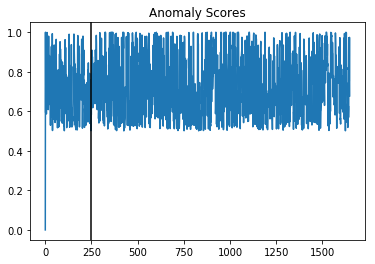

Time:  1.8694560527801514
RMSE:  0.03606479086896221


['anomaly_scores/SARIMA_guide/exchange-2_cpm_results']

In [4]:
save_path = "anomaly_scores/SARIMA_guide/" + dataset_name
output_dict = ad.hwes(gaussian_window_size=gaussian_window_size,slen=24, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# SARIMA: using autoarima

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 24); AIC=-649.953, BIC=-621.910, Fit time=5.107 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=-580.646, BIC=-573.636, Fit time=0.160 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=-643.545, BIC=-629.524, Fit time=0.931 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=-628.895, BIC=-614.874, Fit time=0.772 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 24); AIC=-621.427, BIC=-596.889, Fit time=0.760 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 24); AIC=-651.323, BIC=-619.775, Fit time=20.422 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 0, 24); AIC=-642.692, BIC=-614.650, Fit time=15.696 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 2, 24); AIC=-629.002, BIC=-593.949, Fit time=18.406 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 24); AIC=-639.051, BIC=-614.514, Fit time=1.906 seconds
Fit ARIMA: order=(1, 1, 2

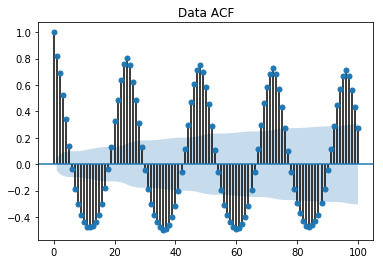

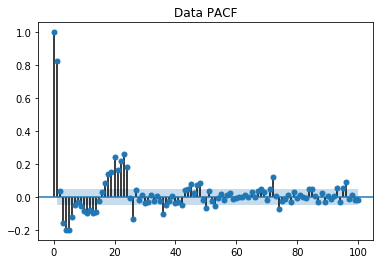

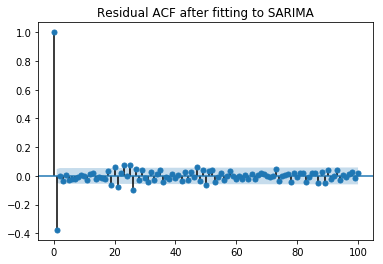

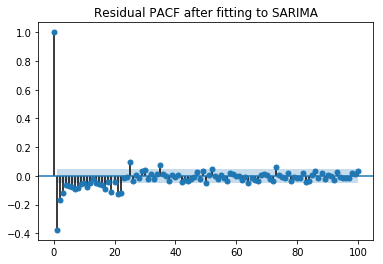

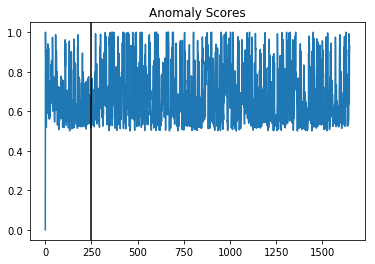

Time:  165.27428817749023
RMSE:  0.08413732910628227


['anomaly_scores/SARIMA_auto/exchange-2_cpm_results']

In [5]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarima(gaussian_window_size=gaussian_window_size,s=24, autoarima=True, autoarima_season=True, plot_acf=True, maxiter=3, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


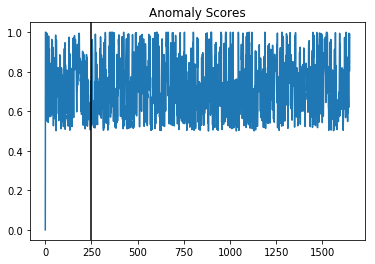

Time:  6.1477370262146
RMSE:  0.07816750175824495


['anomaly_scores/Prophet/exchange-2_cpm_results']

In [6]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size,periods=0, daily_seasonality=True, interval_width=.999, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# RNN

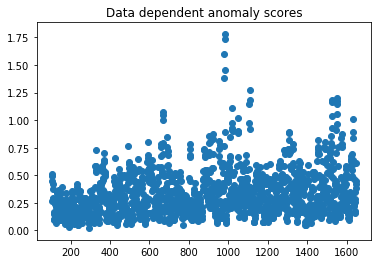

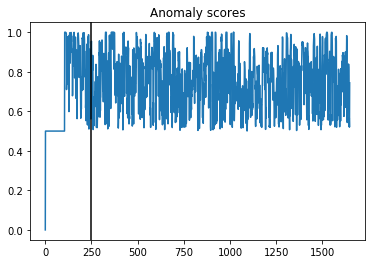

Time:  95.78570055961609


['anomaly_scores/RNN/exchange-2_cpm_results']

In [4]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=5, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

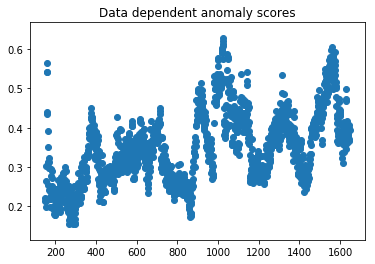

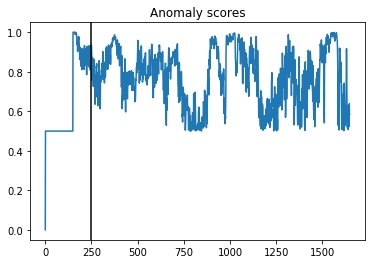

Time:  60.09767484664917


['anomaly_scores/RNN/exchange-2_cpm_results']

In [7]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=50, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

R twitterad completed: True


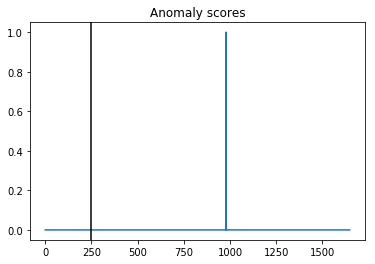

Time:  0.17122960090637207


['anomaly_scores/Twitter/exchange-2_cpm_results']

In [8]:
save_path = "anomaly_scores/Twitter/" + dataset_name
output_dict = ad.twitterad(period=24,max_anoms=2/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HTM

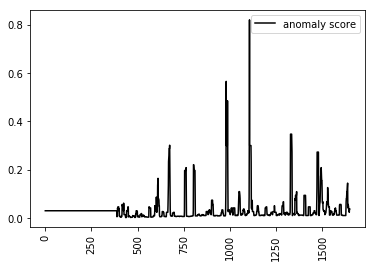

Time:  12.4


['anomaly_scores/HTM/exchange-2_cpm_results']

In [9]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", 12.4)
output_dict = {"Anomaly Scores": anomaly_scores, "Time": 12.4}
joblib.dump(output_dict, save_path)

# Donut

Trainable Parameters              (40,030 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (60,)           60
donut/p_x_given_z/x_mean/kernel  (100, 60)    6,000
donut/p_x_given_z/x_std/bias     (60,)           60
donut/p_x_given_z/x_std/kernel   (100, 60)    6,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (60, 100)    6,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 0, ETA 3.812s] Learning rate decreased to 0

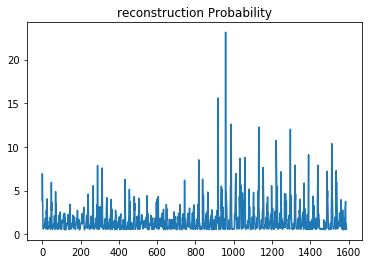

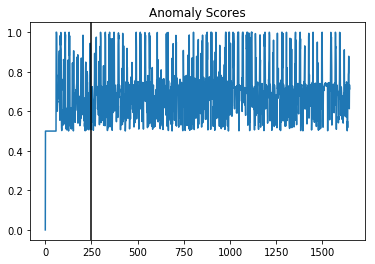

Time:  3.796128988265991


['anomaly_scores/Donut/exchange-2_cpm_results']

In [10]:
save_path = "anomaly_scores/Donut/" + dataset_name
output_dict = ad.donut(gaussian_window_size=gaussian_window_size,window_size=60,plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# STL Resid

R stlplus completed:  no missing True


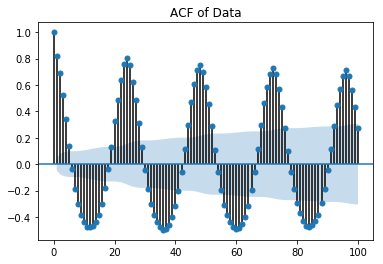

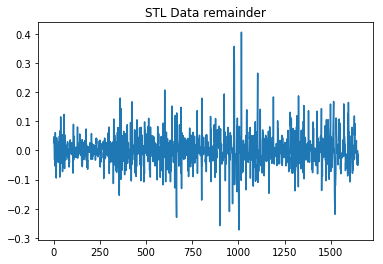

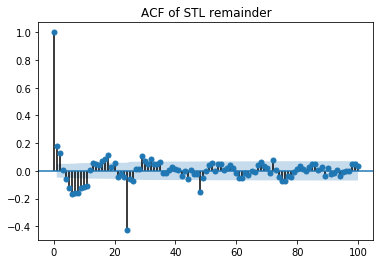

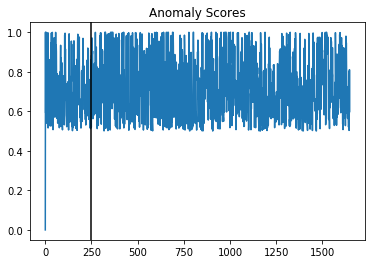

Time:  0.9542350769042969


['anomaly_scores/stl/exchange-2_cpm_results']

In [12]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size,n_periods=24, swindow=7, outer=1, fill_option="linear", plot_resid=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# windowed gaussian

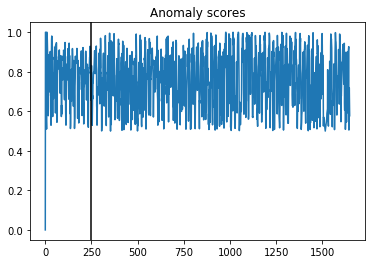

Time:  0.15414047241210938


['anomaly_scores/windowed_gaussian/exchange-2_cpm_results']

In [13]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name
output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size,plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

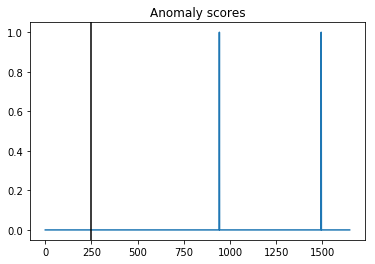

Time:  4.5736589431762695


['anomaly_scores/hotsax/exchange-2_cpm_results']

In [14]:
save_path = "anomaly_scores/hotsax/" + dataset_name
output_dict = ad.hotsax(win_size=50, num_discords=2,
               a_size=3, paa_size=3, z_threshold=0.01,
               plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)